# Multivariate time series: training and analysis

This notebook provides example code you can use for training and analysing your models. Note that **it is not advised** to run and train all models for this assignment in a single notebook. Ideally, in order not to loose your way in your own notebooks, you make **at least** a separate notebook for each type of model in this assignment, selecting only the code you need for that model.

You can get additional inspiration from the "Time series forecasting" demo notebook from the Tensorflow docs:

https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook heavily uses tensorflow utilities we haven't seen in class yet and is sometimes less easy to follow. We use some of the helper functions from that notebook in the code below.

## Imports and Drive mounting


In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os
import pathlib
from sklearn.metrics import mean_absolute_error
# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE


2.4.1


In [2]:
#uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


#!ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive


## Reading the data set

The code below reads the train and test datasets that were generated by the preprocessing notebooks. Obviously: feel free to create your own feature sets, and to change the filenames and paths as you need.


In [6]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/Assignments/GA3/preprocessed_data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

#train_dataset.plot(subplots=True,figsize=(16,26))

## Extract train, validate and test features and labels

In the code below, we will split of a validation set that is the same size as the test set (1 year) at the end of the training set.

In [7]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

#using indexing, you can select which features you want to use (adapt to your needs)
features = range(0,len(train_dataset.columns))

# index of the pollution data in the complete preprocessed feature set 
pollution = 0


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

# data for retraining before testing
train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

# test data
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


# check
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 23)
(26280,)
(8760, 23)
(8760,)
(35040, 23)
(35040,)
(8760, 23)
(8760,)


## Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models. Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.


In [8]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

## Transforming the data into the right format for model training

In this assignment, you will use models with two types of inputs: 
- a dense network that only uses the current input features for prediction
- window-based and sequential networks that use time windows for prediction

In the code below, we define a helper function for each case.

In [11]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

# set chosen window size
WINDOW=6
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=WINDOW)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=WINDOW)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=WINDOW)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=WINDOW)

print(X_train_w.shape)
print(r_train_w.shape)



(26272, 6, 23)
(26272,)


In [13]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualise first 1000 predictions
# PlotResults(r_train_d[:1000],y_train_current[:1000])

In [14]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

The final model type is a recurrent model, which is demonstrated in the code below. Remember that LSTMs and GRUs require the input data to be scaled between 0 and 1!! Since currently, a standardscaler was used, the code below does not give useful results.

In [29]:
#Choose the Window size that will be used to create the lagged features

def construct_model(RNN_WINDOW_SIZE):

  # regularisers - all set to zero for now
  cnn_reg = L1L2(l1=1e-3, l2=1e-1)
  gru_reg = L1L2(l1=1e-3, l2=0)
  dense_reg = L1L2(l1=1e-5, l2=0)

  HIDDEN_RNN = 16
  GRUmodel = Sequential()

  GRUmodel.add(Conv1D(input_shape = (RNN_WINDOW_SIZE, len(train_features)), 
                            filters=16,
                            kernel_size=1,
                            kernel_regularizer=cnn_reg,
                            padding='same'))
  GRUmodel.add(Activation('relu'))
  GRUmodel.add(Conv1D(filters=16,
                          kernel_size=3,
                          padding='same'))
  GRUmodel.add(Activation('relu'))
  GRUmodel.add(MaxPooling1D(pool_size=2))

  GRUmodel.add(Conv1D(input_shape = (RNN_WINDOW_SIZE, len(train_features)), 
                            filters=32,
                            kernel_size=3,
                            kernel_regularizer=cnn_reg,
                            padding='same'))
  GRUmodel.add(Activation('relu'))
  GRUmodel.add(Conv1D(filters=32,
                          kernel_size=3,
                          padding='same'))
  GRUmodel.add(Activation('relu'))
  GRUmodel.add(MaxPooling1D(pool_size=2))

  GRUmodel.add(GRU(units=HIDDEN_RNN,
                   input_shape=(RNN_WINDOW_SIZE,6),
                  return_sequences=False,
                  kernel_regularizer=gru_reg))
  GRUmodel.add(Dense(32,activation='relu',kernel_regularizer=dense_reg))
  GRUmodel.add(Dense(16,activation='relu',kernel_regularizer=dense_reg))
  GRUmodel.add(Dense(8,activation='relu',kernel_regularizer=dense_reg))
  GRUmodel.add(Dense(1))

  GRUmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])

  return GRUmodel

Models will be saved in  /content/gdrive/My Drive//Assignments/GA3/checkpoints/
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 6, 16)             384       
_________________________________________________________________
activation_48 (Activation)   (None, 6, 16)             0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 6, 16)             784       
_________________________________________________________________
activation_49 (Activation)   (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 3, 16)             0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 3, 32)             1568      
_______________________________________

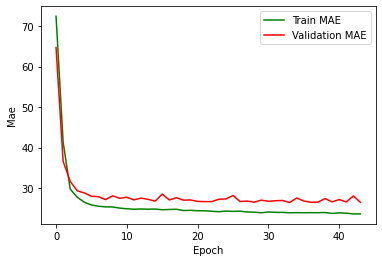

In [30]:
RNN_WINDOW_SIZE = 6

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features
#train_features = [0,] 
train_features = range(0,len(train_dataset.columns)) #Using all features

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=RNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=RNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=RNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=RNN_WINDOW_SIZE)

checkpoint_dir = '/content/gdrive/My Drive//Assignments/GA3/checkpoints/'
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"hybrid_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"

GRUmodel = construct_model(RNN_WINDOW_SIZE)
GRUmodel.summary()

#code for modelcheckpoint and early stopping  commented below
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor='val_mae',
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,min_delta=0.01)

batch_size=128
epochs=100
GRU_history = GRUmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          callbacks = [cp_callback, stopping_callback],
          shuffle=True)

## Reconstruct best model and evaluate performance on train and val set
# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])

# Now restore the model
best_GRUmodel = construct_model(RNN_WINDOW_SIZE) # this is a new model
best_GRUmodel.load_weights(latest)

y_train_GRUmodel = best_GRUmodel.predict(X_train_w)
y_val_GRUmodel = best_GRUmodel.predict(X_val_w)

mae_train = mean_absolute_error(r_train_w,y_train_GRUmodel)
mae_val = mean_absolute_error(r_val_w,y_val_GRUmodel)

print("Best GRU model with early stopping:")
print("Train MAE = ",mae_train)
print("Validation MAE = ",mae_val)

plot_history(GRU_history)

In [31]:
# Code needs to be adapted to the best model so far!!!!
train_features = range(0,len(train_dataset.columns)) #Using all features

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=6)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=6)

#Recreate the best optimal model

final_model = construct_model(6)
final_model.summary()

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])

batch_size=128
epochs=34

final_model_history = final_model.fit(X_train_all_w, r_train_all_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 6, 16)             384       
_________________________________________________________________
activation_56 (Activation)   (None, 6, 16)             0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 6, 16)             784       
_________________________________________________________________
activation_57 (Activation)   (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 3, 16)             0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 3, 32)             1568      
_________________________________________________________________
activation_58 (Activation)   (None, 3, 32)           

In [32]:
y_train_all = final_model.predict(X_train_all_w)
y_test = final_model.predict(X_test_w)

mae_train_all = mean_absolute_error(r_train_all_w,y_train_all)
mae_test = mean_absolute_error(r_test_w,y_test)

print("\"Hybrid\" model:\n train all mae = ",mae_train_all, "\n test mae = ",mae_test)

"Hybrid" model:
 train all mae =  24.55204 
 test mae =  23.817049


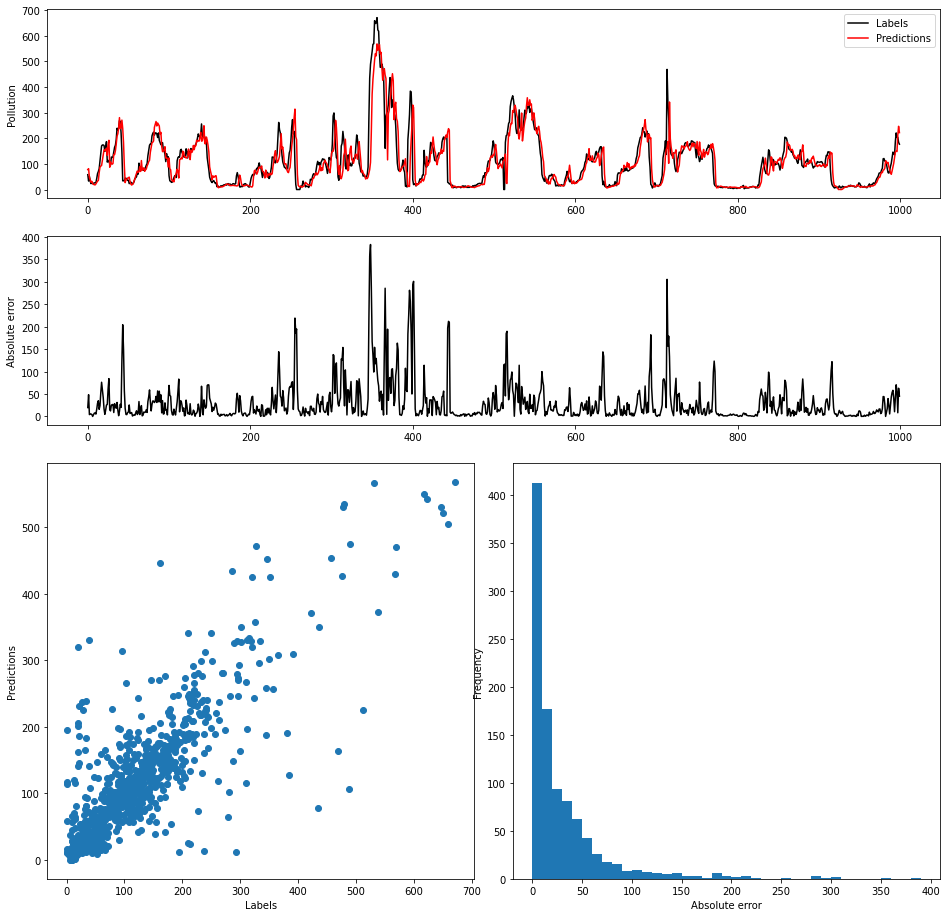

In [33]:
PlotResults(r_test_w[:1000],y_test[:1000,0])